In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = "1"

# Integration functions and QR decomposition
%run ./Functions.ipynb

## Overview

We compute the first N_exp largest Lyapunov exponents of the Lorenz system.

In [2]:
##### Initialize

N_dim     = 3          #Degrees of freedom of the system

N_exp     = 3          #Number of exponents to compute

dt        = .005       #timestep

N_orth    = 100        #number of steps before orthonormalization of the basis
N         = 500000     #length of time series
N_times   = N//N_orth  #total number of orthonormalizations
N_print   = 10         #total number of printed updates during computation

integrator = RK4       #integration scheme
system     = Lorenz    #Right hand side of the governing equations

N_transient = int(200/dt)                       #integration points to reach the attractor
q0          = np.random.random((N_dim))         #random initial condition
q0          = integrator(q0,dt,N_transient,Lorenz) #unperturbed initial condition on the attractor 

eps         = 1.e-9                               #multiplication factor to make the orthonormalized perturbation infinitesimal

SS          = np.empty((N_times, N_exp))          #initialize lyapunov exponents
x0P         = []                                  #initialize perturbations
for ii in range(N_exp):
    q_per    = np.random.rand(N_dim)
    x0P     += [ q0 + eps*(q_per/np.linalg.norm(q_per)) ]      #N_exp randomly perturbed initial conditions

### Algorithm
The first N_exp largest Lyapunov exponents are computed by letting the unperturbed trajectory plus N_exp perturbed trajectories evolve according to the non linear equations.

The evolution of the perturbations is computed as the difference between the perturbed trajectories and the unperturbed trajectory.

Every N_orth integration steps, we orthornormalize the perturbations to compute an orthonormal basis that spans the N_exp-dimensional subspace. 

The average exponential rate of change of the norm of the perturbations along the element of the orthonormal basis provides the largest N_exp Lyapunov exponents.

In [3]:
%%time
#### Compute lyapunov exponents

S           = 0
for jj in range(N_times):
    
    if jj > 0:
        for ii in range(N_exp):
            x0P[ii]      = q0 + eps*aa[ii]                         #perturb initial condition with orthonormal basis
    
    q0   = integrator(q0,dt,N_orth,Lorenz)                         #compute unperturbed trajectory                   
    for ii in range(N_exp):
        x0P[ii]    = integrator(x0P[ii],dt,N_orth,Lorenz)          #compute perturbed trajectories   
            
    a  = []
    for ii in range(N_exp):        
        a  += [(x0P[ii] - q0)/eps]                                #compute the final value of the N_exp perturbations

    aa, S1 = QR(a, N_exp)                                         #orthornormalize basis and compute exponents
    
    if jj > 0:                                                    #skip the first step, which does not start from the orthonormalized basis
        S       += S1
        SS[jj]   = S/(jj*dt*N_orth)
        if jj%(N_times//N_print) == 0: print('Lyapunov exponents, completion percentage:',
                                        SS[jj], jj/N_times)   
    

Lyapunov exponents, completion percentage: [ 9.12054729e-01  1.86637439e-04 -1.45784426e+01] 0.1
Lyapunov exponents, completion percentage: [ 9.21194924e-01 -1.14419192e-03 -1.45863984e+01] 0.2
Lyapunov exponents, completion percentage: [ 9.13846716e-01 -1.50420160e-03 -1.45790088e+01] 0.3
Lyapunov exponents, completion percentage: [ 9.08355827e-01 -1.15177755e-03 -1.45735174e+01] 0.4
Lyapunov exponents, completion percentage: [ 9.05137711e-01 -4.40884589e-04 -1.45707792e+01] 0.5
Lyapunov exponents, completion percentage: [ 9.03385161e-01 -7.84138851e-05 -1.45695396e+01] 0.6
Lyapunov exponents, completion percentage: [ 9.05065250e-01 -1.68202220e-04 -1.45710995e+01] 0.7
Lyapunov exponents, completion percentage: [ 9.07259549e-01 -1.22168918e-04 -1.45733166e+01] 0.8
Lyapunov exponents, completion percentage: [ 9.07030020e-01 -1.02353280e-04 -1.45735666e+01] 0.9
CPU times: user 32.4 s, sys: 8.89 ms, total: 32.4 s
Wall time: 32.4 s


In [4]:
## Compute Kaplan-Yorke dimension
Lyap_exp = SS[-1]
print('Lyapunov exponents      ', Lyap_exp)

if Lyap_exp.sum() > 0:
    print('Error: not enough exponents have been computed. Increase N_exp to compute KY-dimension')

else:
    sums = np.cumsum(Lyap_exp) #cumulative sum of the Lyapunov exponents
    arg  = np.argmax(sums<0)   #index for which the cumulative sum becomes negative

    KY_dim = arg + sums[arg-1] / np.abs(Lyap_exp[arg])

    print('Kaplan-Yorke dimension  ', KY_dim)

Lyapunov exponents       [ 9.07870136e-01 -1.02676552e-04 -1.45743367e+01]
Kaplan-Yorke dimension   2.062285336000624


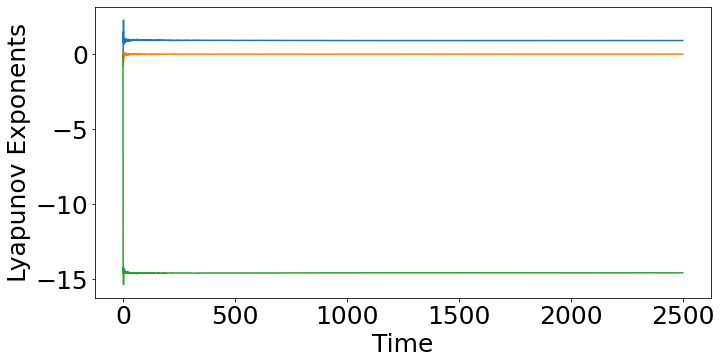

In [5]:
### Plot convergence of the exponents
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 25

plt.plot(np.arange(N_times)*dt*N_orth, SS)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponents')
plt.tight_layout(pad=0.2)
plt.show()